#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

     |████████████████████████████████| 679 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# импортируем все необходимое
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [4]:
# откроем файл и выведем первые 5 строк
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',parse_dates =[0],index_col= 0)
except:
    df = pd.read_csv('taxi.csv',parse_dates =[0],index_col= 0)
    
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
df.isna().sum()

num_orders    0
dtype: int64

In [8]:
# отсортируем индексы и проверим их на монотонность
df = df.sort_index()
print(df.index.is_monotonic)

True


In [9]:
# ресемплируем данные по 1 часу
df = df.resample('1H').sum()

#### Вывод: 

Для анализа мы имеем данные заказов такси за 6 месяцев, с марта по август 2018 года.

1. Изменили тип данных на datetime64.

2. Установили индекс таблицы равным столбцу Datetime.

3. Проверили на наличие пропусков и монотонность.

4. Ресемплировали данные по 1 часу.

## Анализ

In [10]:
decomposed = seasonal_decompose(df)

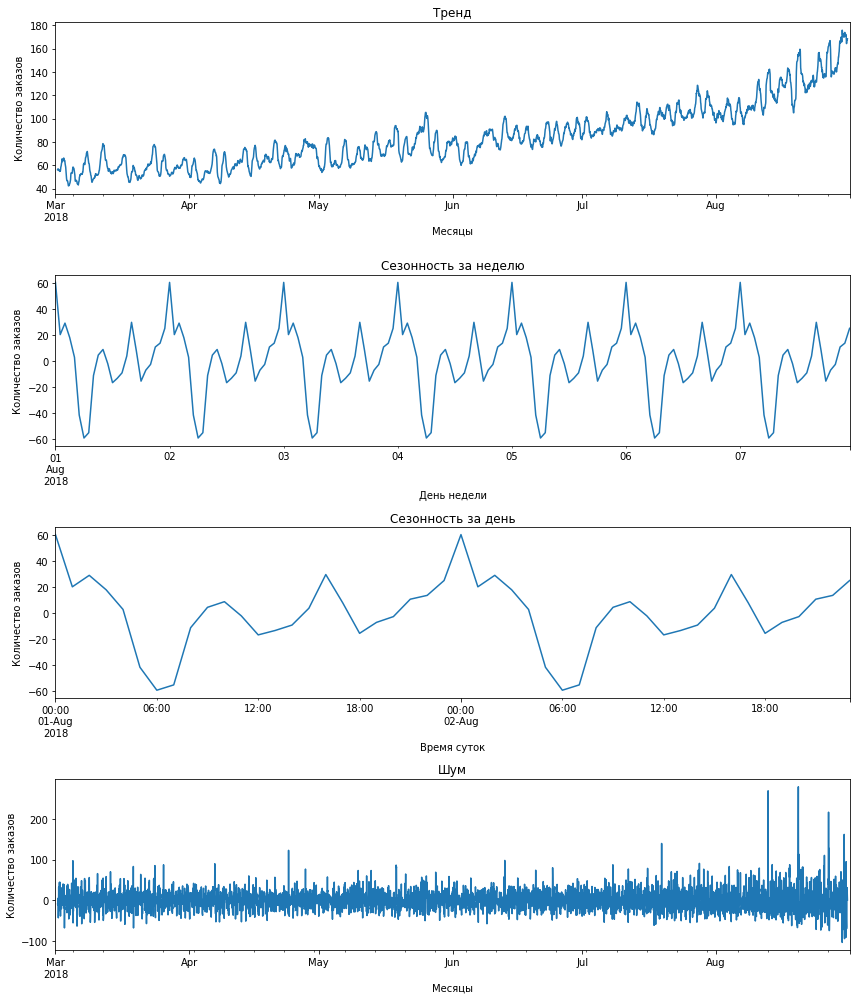

In [11]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 14))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд') # изменение среднего значения ряда 
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.subplot(412)

decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Сезонность за неделю')  
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.subplot(413)

decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Сезонность за день') # циклично повторяющиеся закономерности во временном ряду
plt.xlabel('Время суток')
plt.ylabel('Количество заказов')
plt.subplot(414)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Шум') # компонента, которая не объясняется трендом и сезонностью - шум
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.tight_layout()

Нам даны данные только за 6 месяцев, а тренды и сезонность зависят от масштаба данных, поэтому мы не можем увидеть закономерности, повторяющиеся каждое лето.

1. По графику Тренд можно заметить, что идет увеличение заказов начиная с марта и по конец августа.

2. Сезонность за неделю. По графику можно сделать вывод, что число заказов не меняется в зависимости от дня недели.

3. Сезонность за сутки. Можно отметить, что пиковые активности приходятся на 12 часов ночи, а минимальне число заказов на 6 утра.

4. Шум, который мы объяснить не можем.

Проверили стационарность временного ряда методом shift().

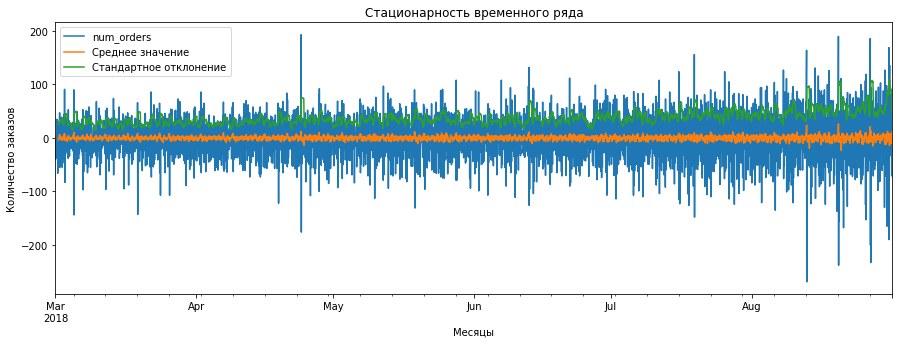

In [12]:
df1 = df - df.shift()
df1['Среднее значение'] = df1['num_orders'].rolling(15).mean()
df1['Стандартное отклонение'] = df1['num_orders'].rolling(15).std()
df1.plot(figsize=(15,5))
plt.title('Стационарность временного ряда') 
plt.xlabel('Месяцы')
plt.ylabel('Количество заказов')
plt.show()

Среднее значение и стандартное отклонение не сильно меняются, следовательно можно сделать вывод, что ряд стационарен. 

## Обучение

In [13]:
# создание функции для признаков
def make_features(df, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    # добавление признака скользящего среднего
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
# отстающие признаки 168(24 часа * 7 дней) и скользящее среднее 24
make_features(df, 168, 24)

In [16]:
# удалим пропуски, которые могли появиться в ходе создания лаговых переменных
df.dropna(inplace=True)

In [17]:
# разделим выборки на обучающую и тестовую
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# проверим размер выборок
display(train.shape)
display(test.shape)

# проверим корректность деления
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3823, 174)

(425, 174)

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [18]:
RANDOM_STATE = np.random.RandomState(12345)

In [19]:
RMSE_train = []

#### Линейная регрессия

In [20]:
# Создание и обучение модели
lr =LinearRegression()
lr.fit(features_train, target_train)

pred_train_lr = lr.predict(features_train)
#pred_test_lr = lr.predict(features_test)

rmse_train_lr = np.sqrt(mean_squared_error(target_train, pred_train_lr))
print("RMSE обучающей выборки =", rmse_train_lr)

RMSE_train.append(rmse_train_lr)

#rmse_test_lr = np.sqrt(mean_squared_error(target_test, pred_test_lr))
#print("RMSE тестовой выборки =", rmse_test_lr)

RMSE обучающей выборки = 20.448198588744702


#### Модель LightGBM

In [ ]:
# Создание модели
lgbm = lgb.LGBMRegressor(random_state = RANDOM_STATE)

# Диапазоны гиперпараметров для перебора
lgbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 50, 100],
    'num_leaves': [20, 30, 50],
    'min_data_in_leaf': [20, 30, 50]
}

tscv = TimeSeriesSplit(n_splits = 5)

# Используем RandomizedSearchCV для поиска по диапазону гиперпараметров и выбора лучшей модели
lgbm_random_search = RandomizedSearchCV( lgbm, lgbm_params,
                                        n_iter=20,
                                        scoring='neg_mean_squared_error',
                                        verbose=2,
                                        random_state = RANDOM_STATE,
                                        cv=tscv,
                                        n_jobs=-1,
                                       )

# Обучение модели
lgbm_random_search.fit(features_train, target_train)

best_lgbm = lgbm_random_search.best_estimator_

pred_train_lgbm = best_lgbm.predict(features_train)
#pred_test_lgbm = best_lgbm.predict(features_test)

rmse_train_lgbm = np.sqrt(mean_squared_error(target_train, pred_train_lgbm))
print("RMSE обучающей выборки:", rmse_train_lgbm)

RMSE_train.append(rmse_train_lgbm)

#rmse_test_lgbm = np.sqrt(mean_squared_error(target_test, pred_test_lgbm))
#print("RMSE тестовой выборки:", rmse_test_lgbm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV] END learning_rate=0.05, min_data_in_leaf=50, n_estimators=10, num_leaves=20; total time=   8.3s
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV] END learning_rate=0.05, min_data_in_leaf=50, n_estimators=10, num_leaves=20; total time=  17.0s
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV] END learning_rate=0.05, min_data_in_leaf=50, n_estimators=10, num_leaves=20; total time=  22.2s
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[CV] END learning_rate=0.05, min_data_in_leaf=50, n_estimators=10, num_leaves=20; total time=  23.6s
[LightGBM] [Warning] min_data_in_leaf is set=5

Сделаем общую таблицу с результатами

In [ ]:
results = {
    'Модель': ['LinearRegression', 'LightGBM'],
    'RMSE обучающей выборки': RMSE_train,
}


RMSE_results = pd.DataFrame(results)
print(RMSE_results)

Наилучший результат показала модель LightGBM:


RMSE обучающей выборки: 15.6767

## Тестирование

In [ ]:
# протестируем наилучшую модель на тестовой выборке
test_prediction = best_lgbm.predict(features_test)
test_rmse = np.sqrt(mean_squared_error(target_test, test_prediction))

print('RMSE для лучшей модели LightGBM:', test_rmse)

In [ ]:
# построим график для исходных данных и для предсказанных
df_plot = test.copy()
df_plot['prediction'] = test_prediction
predict_plot = df_plot[['num_orders', 'prediction']].plot(kind='line', figsize=(15, 5), grid = True)
plt.title('Предсказания модели CatBoost vs Исходные данные')
plt.show()

RMSE лучшей модели LightGBM на тестовой выборке показал резульат 38.44. Уровень метрики соответствует требованиям, значит цель достугнута.

## Вывод.

1. Для анализа мы получили данные заказов такси за 6 месяцев, с марта по август 2018 года. 

Изменили тип данных на datetime64. 

Установили индекс таблицы равным столбцу Datetime. 

Проверили на наличие пропусков и монотонность. 

Ресемплировали данные по 1 часу.

2. Проанализировали графики. Нам предоставлены данные только за 6 месяцев, а тренды и сезонность зависят от масштаба данных, поэтому мы не можем увидеть закономерности, повторяющиеся каждое лето.

По графику Тренд можно заметить, что идет увеличение заказов начиная с марта и по конец августа.

Сезонность за неделю. По графику можно сделать вывод, что число заказов не меняется в зависимости от дня недели.

Сезонность за сутки. Можно отметить, что пиковые активности приходятся на 12 часов ночи, а минимальне число заказов на 6 утра.

Шум, который мы объяснить не можем.

3. Разделили данные на обучающую и тестовую выборки и обучили модели линейной регрессии, LightGBM и CatBoost. Наилучшее значение метрики RMSE показала модель LightGBM:

RMSE обучающей выборки: 15.6767


4. RMSE лучшей модели LightGBM на тестовой выборке показал резульат 38.44.